In [3]:
from skimage import data, exposure, filters, io, segmentation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile as tif
sns.set()
%matplotlib inline

In [19]:
def Vector(x, y, image_2D, savepath):
    
    ## Import picture as array
    
    # im = io.imread(loadpath)
    im = image_2D
    
    ## Set dendritic branching point(dbp) as the maximum value
    
    im[y, x] = 255
    
    ## Save image
    
    io.imsave('%s.png' % savepath, im)
    
    ## Define dbp with the input index (y, x)

    dbp = np.array([y, x])
    
    ## Retrieve the index of all pixel values above a threshold
    
    # pixel_co = np.argwhere(im > np.quantile(im, 0.90))
    pixel_co = np.argwhere(im)        
    
    
    ## Substract the dbp index from every pixel to calculate the vectors
    
    norm_pixel_values = pixel_co - dbp
    
    norm_pixel_values[:,0]*= -1
   
    ## Find vector length to every pixel
    
    vec_length = np.linalg.norm(norm_pixel_values, axis=1)

    ## Delete dbp index
    
    dbp_index = np.argwhere(vec_length == 0)
    
    norm_pixel_values = np.delete(norm_pixel_values, (dbp_index), axis=0)
    
    vec_length = np.delete(vec_length, dbp_index)

    
    ## Normalize vector length 
    
    norm_vectors = norm_pixel_values / vec_length[:, np.newaxis]
    
    ## Add all vectors together 
    
    ori_vec = [norm_vectors.sum(axis=0)]
    
    ## Calculate length of the sum vector
    
    ori_vec_length = np.linalg.norm(ori_vec)
    
    ## Calculate normalized vector in the same orientation as sum vector
    
    norm_ori_vec = ori_vec / ori_vec_length  
    num_pixel = norm_pixel_values.shape[0]

    ## Calculate DGI
    
    DGI = np.divide(ori_vec_length, num_pixel)
    
    ## Plot the vector starting at the dbp in the image together with the used pixels as a scatterplot
    
    ax = plt.subplot(111)
    
    ax.scatter( norm_pixel_values[:, 1], norm_pixel_values[:, 0], marker = '.', alpha = 0.5)
    ax.arrow( 0, 0, 50*norm_ori_vec[0, 1], 50*norm_ori_vec[0,0], width = 1, head_width= 5, head_length=5, fc='k', ec='k')
    ax.axis('equal')
    plt.savefig('%s_scatter.png' % savepath, dpi = 1000)
    
    
    plt.show()
    
    ## Save Data to csv file
    
    np.savetxt("%s.csv" % savepath, norm_vectors, fmt="%.10f", delimiter=',')
    print(num_pixel)
    return(norm_ori_vec, norm_vectors, DGI, num_pixel)
            

In [20]:
loadpath = '/Users/aichah/Desktop/TLI/data/montage/stable_211107_P36_N2_1.tif'
image_2D = tif.imread(loadpath)
image_2D.shape

(88, 37, 2, 400, 400)

In [21]:
image_2D = image_2D[85,:,1]
image_2D = image_2D.max(axis=0)

In [22]:
image_2D.shape

(400, 400)

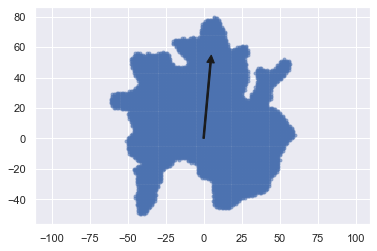

9001


In [23]:
savepath = '/Users/aichah/Desktop/TLI/data/montage/'
a, b, c, d = Vector(150,275, image_2D, savepath)


In [32]:
a

array([[0.9958061 , 0.09148885]])

In [45]:
def dendritic_polarplot(sine, cos, nbins, norm_ori_vec, DGI, savepath, num_pixel, num_pixel_Adult):
    
  ## Convert vector coordinates into degree
    angles = np.arctan2(cos, sine)
    vec_angles = np.degrees(angles)
    
    ## Separate the vectors into different bins according to directions
    
    histo = np.histogram(vec_angles, bins = nbins)
    # histo = np.array(histo)
    
    ## Colour the bars differently
    
    cmap_hist = sns.husl_palette(nbins)
    
    ## Normalize the bar length (Normalized to Adult pixel number)
    
    bar_length = []
    for elem in histo[0]:
        bar_length.append(elem/num_pixel_Adult)
    bar_length.append(0)
    bar_length = np.array(bar_length)
    
    ## Add the normalized orientation vector of the dendrite
    
    ori_angle = np.degrees(np.arctan2(-norm_ori_vec[0, 1], -norm_ori_vec[0, 0]))
    
    ## Round DSI to 3 decimals
    
    DGI = round(DGI, 4)
    
    ## Make polar plot and add vector
    
    ax = plt.subplot(111, polar=True)
    
    bins = np.arange(0.0, 2*np.pi, 2*np.pi/nbins)
    bars = ax.bar(-bins-(np.pi/2), 3*bar_length[:-1], width = np.repeat(2*np.pi/nbins, nbins), bottom=0.0, alpha = 0.4)
    arrow = ax.arrow((-ori_angle/180*np.pi)-np.pi/2, 0, 0, (DGI*(num_pixel/num_pixel_Adult)), 
                    head_width = 0.08, head_length = 0.05,label = DGI, fc='k', ec='k')
    
    ax.set_rticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8])
    # ax.set_yticklabels(['', 0.2, '', 0.4, '', 0.6, '', 0.8])
    ax.set_rlabel_position(-ori_angle+90)
#     legend = ax.legend(loc = 'upper right', bbox_to_anchor=(1.08,1.08), handles = [arrow])
    # ax.set_xticklabels(['', '', '', '', '', '', '', ''])
#     plt.setp(plt.gca().get_legend().get_texts(), fontsize='16')
    
    for i in range(len(bars)):
        bars[i].set_facecolor(cmap_hist[i])
        bars[i].set_alpha(0.4)
        bars[i].set_edgecolor('k')
    plt.savefig('%s_plot.png' % savepath, dpi = 1000)
    plt.show()

    print(bar_length)
    
    return True

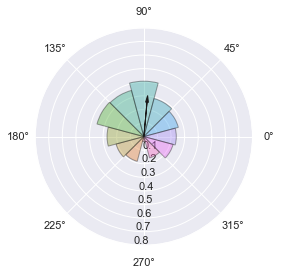

[0.01222086 0.0628819  0.07054772 0.0903233  0.11898678 0.1172092
 0.13587379 0.09654483 0.08754583 0.07954672 0.07421398 0.0541051
 0.        ]


In [46]:
z= dendritic_polarplot(b[:,0], b[:,1], 12, a, c, savepath, d, d)